In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from laspy.file import File
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

%matplotlib notebook
import plotly.graph_objects as go

In [2]:
# Load the data using laspy
inFile = File('../../Data/170204/10552_NYU_M2 - Scanner 1 - 190511_170204_1 - originalpoints.laz', mode='r')

# raw is a 1-D numpy array, each entry is a point
raw = inFile.get_points()

print("Number of points, full waveform: ",len(raw))

OSError: No such file or directory: '/home/michael/lidar/Data/170204/10552_NYU_M2 - Scanner 1 - 190511_170204_1 - originalpoints.laz'

In [4]:
nyc_file_dir = '../../Data/NYC_topo/'
nyc_pt_file = ['las_points_NYC_flightid_975172.lz']
nyc = pd.read_hdf(nyc_file_dir+nyc_pt_file[0])

In [18]:
nyc.sort_values(by=['gps_time'],inplace=True)

In [ ]:
# Corresponds to LAS 1.4 Point Data Record Format 9
# X coordinate of the point (must be adjusted by offset and scale factor)
columns_fwf =[ 
    'X', 
    'Y',
    'Z',
    'intensity', #Intensity of the return, scaled to a 0-65,535 scale
    'flag_byte', #Return number, # of returns, Scan direction flag (+ or -), Edge of flight line flag
    'classification_flags', #Only if the point has been classified: vegetation, etc.
    'classification_byte', #Various flags about the point
    'user_data', 
    'scan_angle', # Down is 0.0, each unit is 0.006 degrees, 
    #so value between -30,000 and 30,000, or (180deg/0.006deg)
    #Spec says this incorporates the roll of the aircraft
    'pt_src_id', #Unique ID for the source of the point
    'gps_time', #GPS Week Time (seconds, reset each week) or Adj Std GPS Time
    'wave_packet_desc_index', # Indicates which waveform packet descriptor is applied.
    'byte_offset_to_waveform_data', # Locates the WF data in EVLR or .wdp file.
    'wavefm_pkt_size', # Size of the waveform packet
    'return_point_waveform_loc', # Time in picoseconds 
    'x_t', # Form parametric location: X = X_0 + x_t*t
    'y_t', # (X_0,Y_0,Z_0) is the anchor point associated with the waveform
    'z_t' ]

# Corresponds to LAS 1.4 Point Data Record Format 6
columns_point_cloud = [
    'X',
    'Y',
    'Z',
    'intensity',
    'flag_byte',
    'classification_flags',
    'classification_byte',
    'user_data',
    'scan_angle',
    'pt_src_id',
    'gps_time']

# Corresponds to LAS 1.2 Point Data Record Format 1
columns_dublin_pt_cloud = [
    'X',
    'Y',
    'Z',
    'intensity',
    'return_number_byte',
    'classification_byte',
    'scan_angle',
    'user_data',
    'pt_src_id',
    'gps_time']

In [ ]:
def raw_to_df(raw,column_names):
    '''function takes raw output of laspy.File.get_points() and column names, and returns a pandas Dataframe'''
    raw_list = [a[0].tolist() for a in raw]
    df = pd.DataFrame(raw_list,columns = column_names)
    return df

def scale_and_offset(df,header,append_to_df=False):
    '''Function takes as input the dataframe output of raw_to_df and the laspy header file.
       Output is a nx3 dataframe with adjusted X,Y, and Z coordinates, from the formula: 
       X_adj = X*X_scale + X_offset.
       Brooklyn LiDAR readings appear to be in feet, and use NAVD 88 in the vertical and 
       New York Long Island State Plane Coordinate System NAD 33 in the horizontal.'''
    offset = header.offset
    scale = header.scale
    scaled_xyz = df[['X','Y','Z']]*scale + offset
    if append_to_df:
        df['x_scaled'] = scaled_xyz['X']
        df['y_scaled'] = scaled_xyz['Y']
        df['z_scaled'] = scaled_xyz['Z'] 
        return df
    else:
        return scaled_xyz

#INACTIVE FUNCTIONS
def split_and_strip(raw):
    '''Function takes the output ndarray of laspy File.get_points(), 
        splits each point on commas, 
        outputs a list of lists.'''
    output_list = []
    for row in raw:
        stripped = [a.strip("( , )") for a in str(row).split(',')]
        output_list.append(stripped)
    return output_list

def row_clean(string_list):
    '''Function takes as input a list of lists, the output of split_and_strip().  Cleans the entries for spaces,
    returns a numpy array where each row is a point.'''
    output_list = []
    for row in string_list:        
        output_list.append(list(map(float,row[:-1])))
    output_arr = np.array(output_list)
    return output_arr


In [ ]:
# Create dataframes for point cloud and fwf
df = raw_to_df(raw,columns_point_cloud)

# Generate adjusted coordinates for point cloud.  FWF is identical.
las_points = scale_and_offset(df,inFile.header,append_to_df=True)
las_points.to_pickle("../../Data/pickles/las_points_170204.pkl")

In [ ]:

#las_points = pd.read_pickle("../../Data/parking_lot//las_points_164239.pkl")

## Flat surface
Identifying points in a parking lot to assess how consistently flat they are.  
Center point: 40.645872, -74.025991  
Easting - 977037.343  
Northing - 174586.034     

In [ ]:
# Extract points within a square around the desired point
pt_x = 977037.343
pt_y = 174586.034
feet_from_point = 4

square_points = las_points[ (las_points['x_scaled'] < pt_x + feet_from_point)
           &(las_points['x_scaled'] > pt_x - feet_from_point) 
           &(las_points['y_scaled'] < pt_y + feet_from_point)
           &(las_points['y_scaled'] > pt_y - feet_from_point)
          ]
print("Point count in square: {:d}".format(square_points.shape[0]))

In [ ]:
square_points[['x_scaled','y_scaled','z_scaled']].describe()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(x=square_points['x_scaled'], 
                                   y=square_points['y_scaled'], 
                                   z=square_points['z_scaled'],
                                   mode='markers',
                                  marker=dict(size=4,
                                              color=2))])

fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[977030,977045],),
                     yaxis = dict(nticks=4, range=[174581,174591],),
                     zaxis = dict(nticks=4, range=[7,8],),),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))

fig.show()

## Nearby Points
Looking at points around the end of the scan angle (nearby_df), as well points near the middle of the scan angle, directly down (down_df).  There seems to be some noise in the points at the end of the scan angle.

In [ ]:
# A handful of points at the end of the scan angle of file las_points_164239.pkl
nearby_points = list(range(32645,32653))+list(range(33760,33767))+list(range(34870,34877))
nearby_df = las_points.iloc[nearby_points]
# Time range
print("Time range: ",nearby_df['gps_time'].max() - nearby_df['gps_time'].min())

In [ ]:
# Filter for points between -1 and 1 degrees scan angle
down_df = las_points[(las_points['scan_angle']<60)&(las_points['scan_angle']>-60)]

In [ ]:
#Helicopter scan lines
plt.plot(down_df['gps_time'][10000:10100],down_df['y_scaled'][10000:10100],'xb')

In [ ]:
nearby_df[['x_scaled','y_scaled','z_scaled']]

### Looking for specific Lat/Lon

In [ ]:
def convert_lat_lon_to_dec(degrees,minutes,seconds):
    return degrees + (minutes/60) + (seconds/3600)
lat = convert_lat_lon_to_dec(40,38,38.8)
lon = convert_lat_lon_to_dec(74,1,33.0)*-1
print("Latitude: {:2.4f}".format(lat))
print("Longitude: {:2.4f}".format(lon))

## Profiling the Brooklyn data
Looking at maximum coordiates, points per scan, scans per run, distance between points, etc.

### Find max North, South, East, West points
Max North: 164039
Max South: 163206
Max East: 172201
Max West: 194702

In [ ]:
def max_cardinal_direction(filename,direction):
    '''Fucntion determines the maximum coordinate in the file in the given direction.'''
    # Load the file
    inFile = File(filename, mode='r')
    if direction == "North":
        return inFile.header.max[1]
    elif direction == "South":
        return inFile.header.min[1]
    elif direction == "East":
        return inFile.header.max[0]
    elif direction == "West":
        return inFile.header.min[0]

In [ ]:
max_north_file = '10552_NYU_M2 - Scanner 1 - 190511_164039_1 - originalpoints.laz'
max_south_file = '10552_NYU_M2 - Scanner 1 - 190511_163206_1 - originalpoints.laz'
max_east_file = '10552_NYU_M2 - Scanner 1 - 190511_172201_1 - originalpoints.laz'
max_west_file = '10552_NYU_M3 - Scanner 1 - 190511_194702_1 - originalpoints.laz'

maxes=[]

# for card in zip([max_north_file,max_south_file,max_east_file,max_west_file],['North','South','East','West']):
#     maxes.append(max_cardinal_direction('../../Data/max_coordinate_point_clouds/'+card[0],card[1]))

In [ ]:
inFile = File('../../Data/max_coordinate_point_clouds/10552_NYU_M2 - Scanner 1 - 190511_164039_1 - originalpoints.laz', mode='r')
# raw = inFile.get_points()
# df = raw_to_df(raw,columns_point_cloud)
# las_points = scale_and_offset(df,inFile.header,append_to_df=True)

### Point density in time and space

In [6]:
def points_per_scan(scan_angle):
    '''takes scan_angle as Series, counts the number of "jumps" in the scan angle, indicating start of a new scan
    then divides the number of points in scan_angle to return points / scan'''
    delta_angle = [scan_angle.iloc[i+1]-scan_angle.iloc[i] for i in range(len(scan_angle)-1)]
    print("Done")
    scan_count = sum(abs(np.array(delta_angle)) > scan_angle.max())
    print("Number of scans: {}".format(scan_count))
    print("Points per scan: {:2.2f}".format(len(scan_angle)/scan_count))
    return len(scan_angle)/scan_count, scan_count

def scans_per_second(gps_time_series,scan_count):
    run_time = gps_time_series.max() - gps_time_series.min()
    print("Scans per second: {:2.2f}".format(scan_count/run_time))
    print("Points per second: {:2.2f}".format(len(gps_time_series)/run_time))
    return scan_count/run_time

def small_angle_no_jumps(df,max_angle=330):
    '''This function extracts only the points with scan angle below max_angle.  
        scan_angle is scaled to .006 degrees per unit.'''
    
    small_angle = df[abs(df['scan_angle'])<max_angle]
    return small_angle

def mean_euclidean_distance(df):
    '''Calculate the mean distance between consecutive points in a dataframe, skipping the jumps between scans.'''
    df['x_dist_to_next'] = np.zeros(len(df))
    df['y_dist_to_next'] = np.zeros(len(df))
    df['x_dist_to_next'][1:] = np.array([df['x_scaled'].iloc[i] - df['x_scaled'].iloc[i-1] for i in range(1,len(df))])
    df['y_dist_to_next'][1:] = np.array([df['y_scaled'].iloc[i] - df['y_scaled'].iloc[i-1] for i in range(1,len(df))])
    
    # Remove jumps in scan angle
    no_jump = df[abs(df['angle_change'])<20]
    
    eucl_dist_to_next = np.sqrt(no_jump['x_dist_to_next']**2+no_jump['y_dist_to_next']**2)
    print("Avg Euclidean distance between points: {:2.2f}".format(eucl_dist_to_next.mean()))
    return eucl_dist_to_next.mean()

def distance_between_points(df,small_angle_max = 330):
    '''Wrapper for mean_euclidean_distance that also looks at points restricted to small angles near 
        directly 0, or the downward direction.'''
    #Add angle_change to identify jumps to new scans.
    df['angle_change'] = np.zeros(len(df))
    df['angle_change'].iloc[1:] = [df['scan_angle'].iloc[i]-df['scan_angle'].iloc[i-1] for i in range(1,len(df))]
    mean_distance_overall = mean_euclidean_distance(df)
    # Small scan_angle
    small_angle_df = small_angle_no_jumps(df,max_angle = small_angle_max)
    mean_distance_small_angle = mean_euclidean_distance(small_angle_df)
    
def create_use_range(filename,column_names):
    '''Function takes .laz filename, returns a 2 million point datafame from the .laz file 
    Also adds scaled xyz coordinates.'''
    
    inFile = File('../../Data/dublin_sample/'+filename, mode='r')
    print("inFile Done")
    raw = inFile.get_points()
    print("get_points done")
    df = raw_to_df(raw[2000000:3000000],column_names)
    print("df done")
    del(raw)
    las_points = scale_and_offset(df,inFile.header,append_to_df=True)
    print("las_points created")
    print("Timespan: {:2.2} seconds".format(las_points['gps_time'].max()-las_points['gps_time'].min()))
    use_range = las_points
    return use_range

def process_use_range(use_range,filename="dublin",small_angle_max = 330):
    '''Runs the profiling on the provided use_range.'''
    
    print("\n",filename,"\n---------------------------------")
    pts_per_scan, scan_count = points_per_scan(use_range['scan_angle'])
    scans_per_second(use_range['gps_time'],scan_count)    
    distance_between_points(use_range,small_angle_max = small_angle_max)

In [26]:
pts_per_scan, scan_count = points_per_scan(nyc['scan_angle'][1100000:2000000])
scans_per_second(nyc['gps_time'][1100000:2000000],scan_count)

Done
Number of scans: 0
Points per scan: inf
Scans per second: 0.00
Points per second: 208683.04


/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning:

divide by zero encountered in long_scalars

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning:

divide by zero encountered in long_scalars



0.0

In [25]:
nyc['gps_time'][1100000:2000000].max()-nyc['gps_time'][1100000:2000000].min()

4.312760591506958

In [28]:
(2000000-1100000)/4.31276

208683.07070182436

In [34]:
scan_angle = np.array(nyc['scan_angle'][1100000:2000000])
delta_angle = [scan_angle[i+1]-scan_angle[i] for i in range(len(scan_angle)-1)]
scan_count = sum(abs(np.array(delta_angle)) > scan_angle.max())
scan_count

0

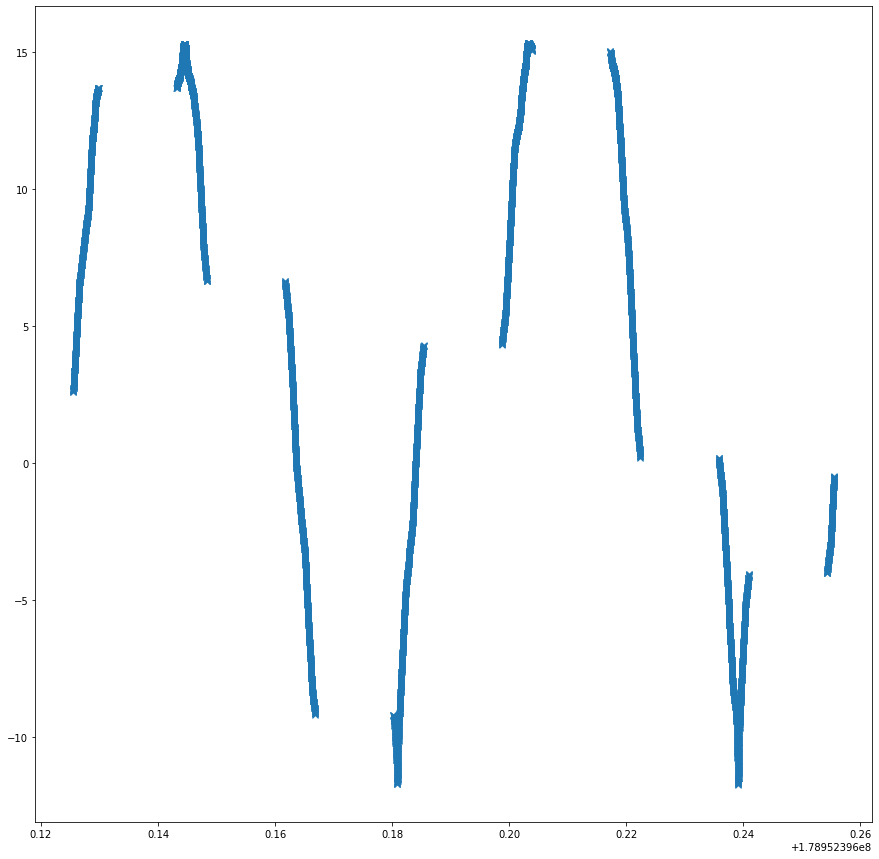

In [49]:
plt.figure(figsize=[15,15])
plt.plot(nyc['gps_time'][840000:850000],scan_angle[840000:850000]*0.006,'x')

In [50]:
1/.06

16.666666666666668

In [ ]:
# Profiling for 4 Brooklyn datasets

max_north_file = '10552_NYU_M2 - Scanner 1 - 190511_164039_1 - originalpoints.laz'
max_south_file = '10552_NYU_M2 - Scanner 1 - 190511_163206_1 - originalpoints.laz'
max_east_file = '10552_NYU_M2 - Scanner 1 - 190511_172201_1 - originalpoints.laz'
max_west_file = '10552_NYU_M3 - Scanner 1 - 190511_194702_1 - originalpoints.laz'

pd.set_option('mode.chained_assignment', None)

for filename in [max_north_file,max_south_file,max_east_file,max_west_file]:
    inFile = File('../../Data/max_coordinate_point_clouds/'+filename, mode='r')
    raw = inFile.get_points()
    df = raw_to_df(raw,columns_point_cloud)
    las_points = scale_and_offset(df,inFile.header,append_to_df=True)
    use_range = las_points[2000000:6000000]
    print("\n",filename,"\n---------------------------------")
    print("Timespan: {:2.2} seconds".format(las_points['gps_time'].max()-las_points['gps_time'].min()))
    pts_per_scan, scan_count = points_per_scan(use_range['scan_angle'])
    scans_per_second(use_range['gps_time'],scan_count)
    
    distance_between_points(use_range)
    
pd.reset_option('mode.chained_assignment')

In [ ]:
''' Brooklyn profiling output
 10552_NYU_M2 - Scanner 1 - 190511_164039_1 - originalpoints.laz 
---------------------------------
Done
Number of scans: 1553
Points per scan: 2575.66
Scans per second: 133.26
Points per second: 343224.78
Avg Euclidean distance between points: 2.52
Avg Euclidean distance between points: 0.92

 10552_NYU_M2 - Scanner 1 - 190511_163206_1 - originalpoints.laz 
---------------------------------
Done
Number of scans: 1974
Points per scan: 2026.34
Scans per second: 133.31
Points per second: 270123.17
Avg Euclidean distance between points: 0.90
Avg Euclidean distance between points: 1.05

 10552_NYU_M2 - Scanner 1 - 190511_172201_1 - originalpoints.laz 
---------------------------------
Done
Number of scans: 2276
Points per scan: 1757.47
Scans per second: 133.29
Points per second: 234249.32
Avg Euclidean distance between points: 0.97
Avg Euclidean distance between points: 1.19

 10552_NYU_M3 - Scanner 1 - 190511_194702_1 - originalpoints.laz 
---------------------------------
Done
Number of scans: 1593
Points per scan: 2510.99
Scans per second: 133.25
Points per second: 334601.09
Avg Euclidean distance between points: 2.71
Avg Euclidean distance between points: 0.88
'''

In [ ]:
# Profiling for 4 Dublin datasets
# Note This did not really work...the Dublin files have weird scan angle patterns.

dublin_files = [
    'F_150326_120854.laz',
    'F_150326_122941.laz',
    'F_150326_145523.laz',
    'F_150326_150906.laz'
]

pd.set_option('mode.chained_assignment', None)

for filename in dublin_files:
    use_range = create_use_range(filename,columns_dublin_pt_cloud)
    process_use_range(use_range,filename,small_angle_max = 2)
    
pd.reset_option('mode.chained_assignment')

In [ ]:
# Find points at similar scan angles across all scans.
consecutive = use_range[(use_range['scan_angle']<206)&(use_range['scan_angle']>200)]

def euclidean_dist_consecutive_scans(consecutive):
    '''Function takes a dataframe of points within a very tight scan_angle, but across many scans.
        Function determines points on consecutive scans, then calculates the x-y distance between 
        those points on consecutive scans and prints out the average across the full dataframe.'''
    euc_dist_list = []
    for i in range(1,len(consecutive)):
        record_dist = consecutive.iloc[i].name - consecutive.iloc[i-1].name
        if (record_dist>1000) & (record_dist < 3000):
            euc_dist = np.sqrt((consecutive['x_scaled'].iloc[i]-consecutive['x_scaled'].iloc[i-1])**2+
                           (consecutive['y_scaled'].iloc[i]-consecutive['y_scaled'].iloc[i-1])**2)
            euc_dist_list.append(euc_dist)
    print("Mean euclidean distance between consecutive scans: {2.2f}".format(np.mean(euc_dist_list)))